Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Education/Master/artifacts/upgrad/melanoma cnn assignment/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Education/Master/artifacts/upgrad/melanoma cnn assignment/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train
                                                               ,seed=123
                                                               ,validation_split=.2
                                                               , subset='training'
                                                               ,image_size=(img_height,img_width)
                                                               ,batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train
                                                               ,seed=123
                                                               ,validation_split=.2
                                                               , subset='validation'
                                                               ,image_size=(img_height,img_width)
                                                               ,batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### create a code to visualize one instance of all the nine classes present in the dataset

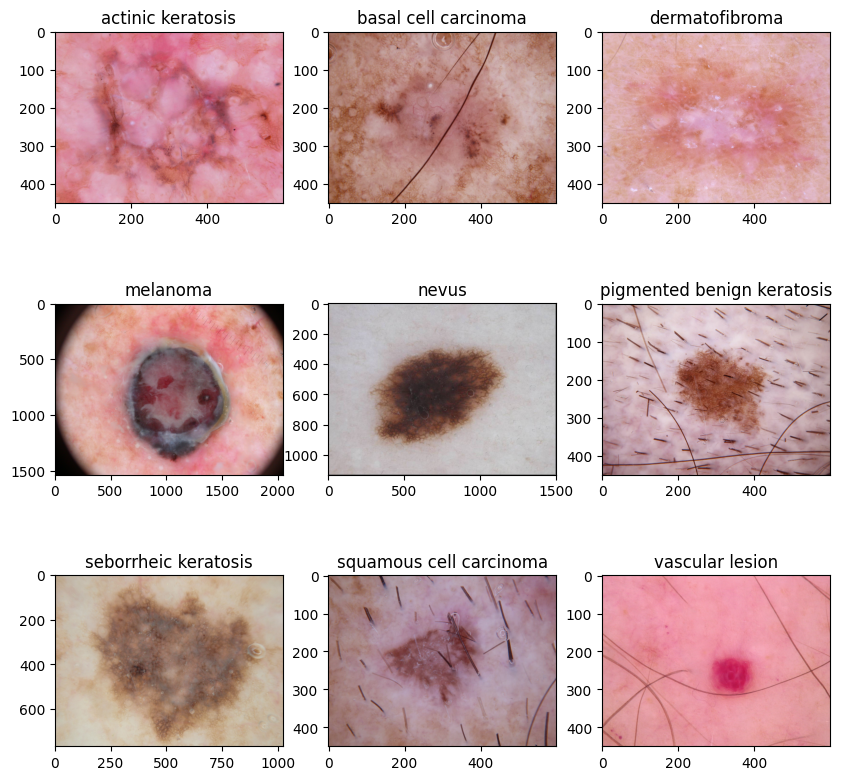

In [ ]:
### training or validation data to visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### choosing an appropirate optimiser and loss function
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [ ]:
#Train the model with 20 epochs
epochs = 20

lc = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
history = model.fit(
  train_ds,
  callbacks=[lc],
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 623s 2s/step - loss: 2.0552 - accuracy: 0.1897 - val_loss: 2.0502 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 1.9832 - accuracy: 0.2433 - val_loss: 1.8823 - val_accuracy: 0.1790 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 1.8695 - accuracy: 0.2958 - val_loss: 1.7300 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 1.7237 - accuracy: 0.3544 - val_loss: 1.6995 - val_accuracy: 0.3579 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6277 - accuracy: 0.3962 - val_loss: 1.6247 - val_accuracy: 0.4116 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6320 - accuracy: 0.3895 - val_loss: 1.5865 - val_accuracy: 0.4497 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5579 - accur

### Visualizing training results

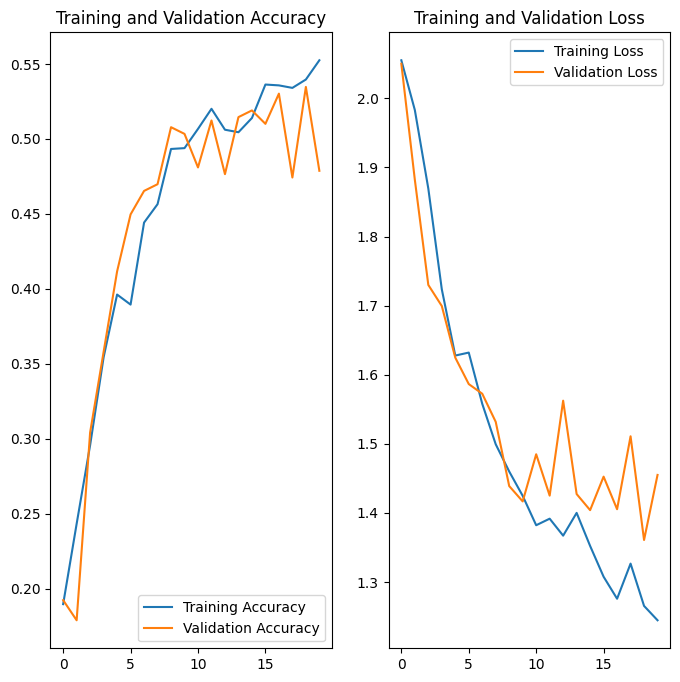

In [ ]:
###plotting traing and validation accuracy & loss

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis post the model fit, see if there is an evidence of model overfit or underfit

It is too early to comment whether the model is overfitting or underfitting, Validation accuray and Training accuracy follow each other.

The training loss is low but validation loss is fluctuating based on the observation


### Write your findings here

In [ ]:
# Analyse the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
#
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

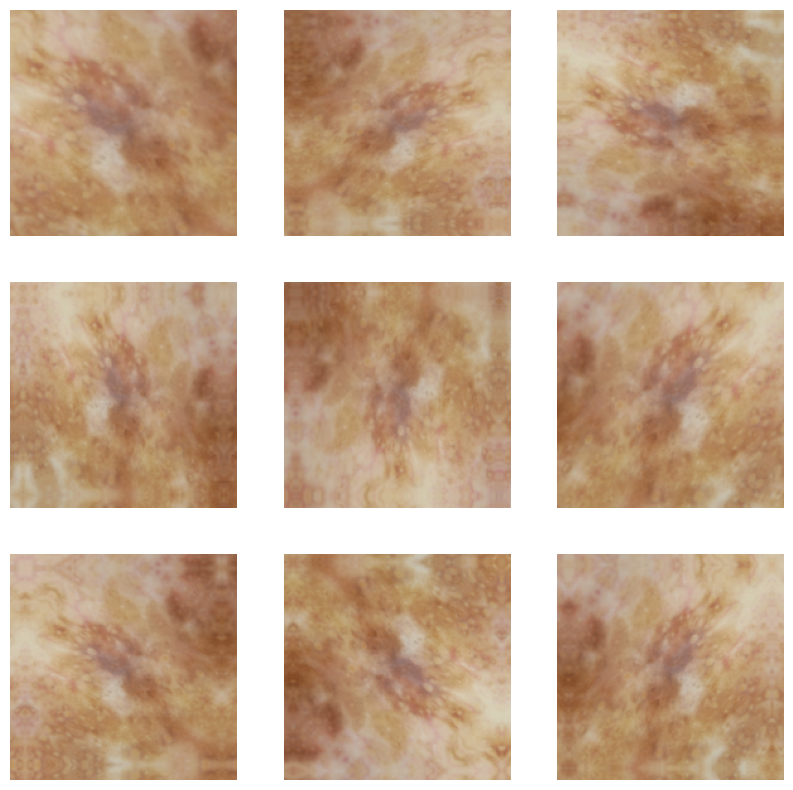

In [ ]:
# visualizing the augmentation strategy how it works for one instance of training image.
#

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## Using Dropout layer if there is an evidence of overfitting in the findings

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

### Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [ ]:
## train the model for 20 epochs
epochs=20
lc = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

history = model.fit(
  train_ds,
  callbacks=[lc],
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 64ms/step - loss: 2.0699 - accuracy: 0.2059 - val_loss: 2.0670 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 4s 65ms/step - loss: 2.0279 - accuracy: 0.2020 - val_loss: 2.0402 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 59ms/step - loss: 2.0250 - accuracy: 0.1987 - val_loss: 2.0230 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 58ms/step - loss: 2.0194 - accuracy: 0.1936 - val_loss: 2.0221 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 2.0234 - accuracy: 0.2137 - val_loss: 2.0232 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - ETA: 0s - loss: 2.0149 - accuracy: 0.1959
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 [==============================] - 3s 57ms/step - los

### Visualizing the results

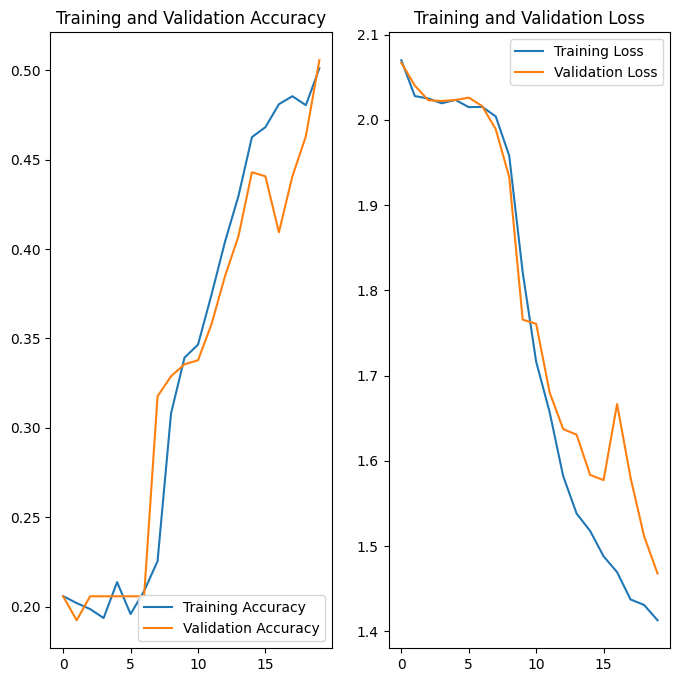

In [ ]:
###plotting traing and validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The accuracy remains the same as before. But still low accuracy

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

<BarContainer object of 9 artists>

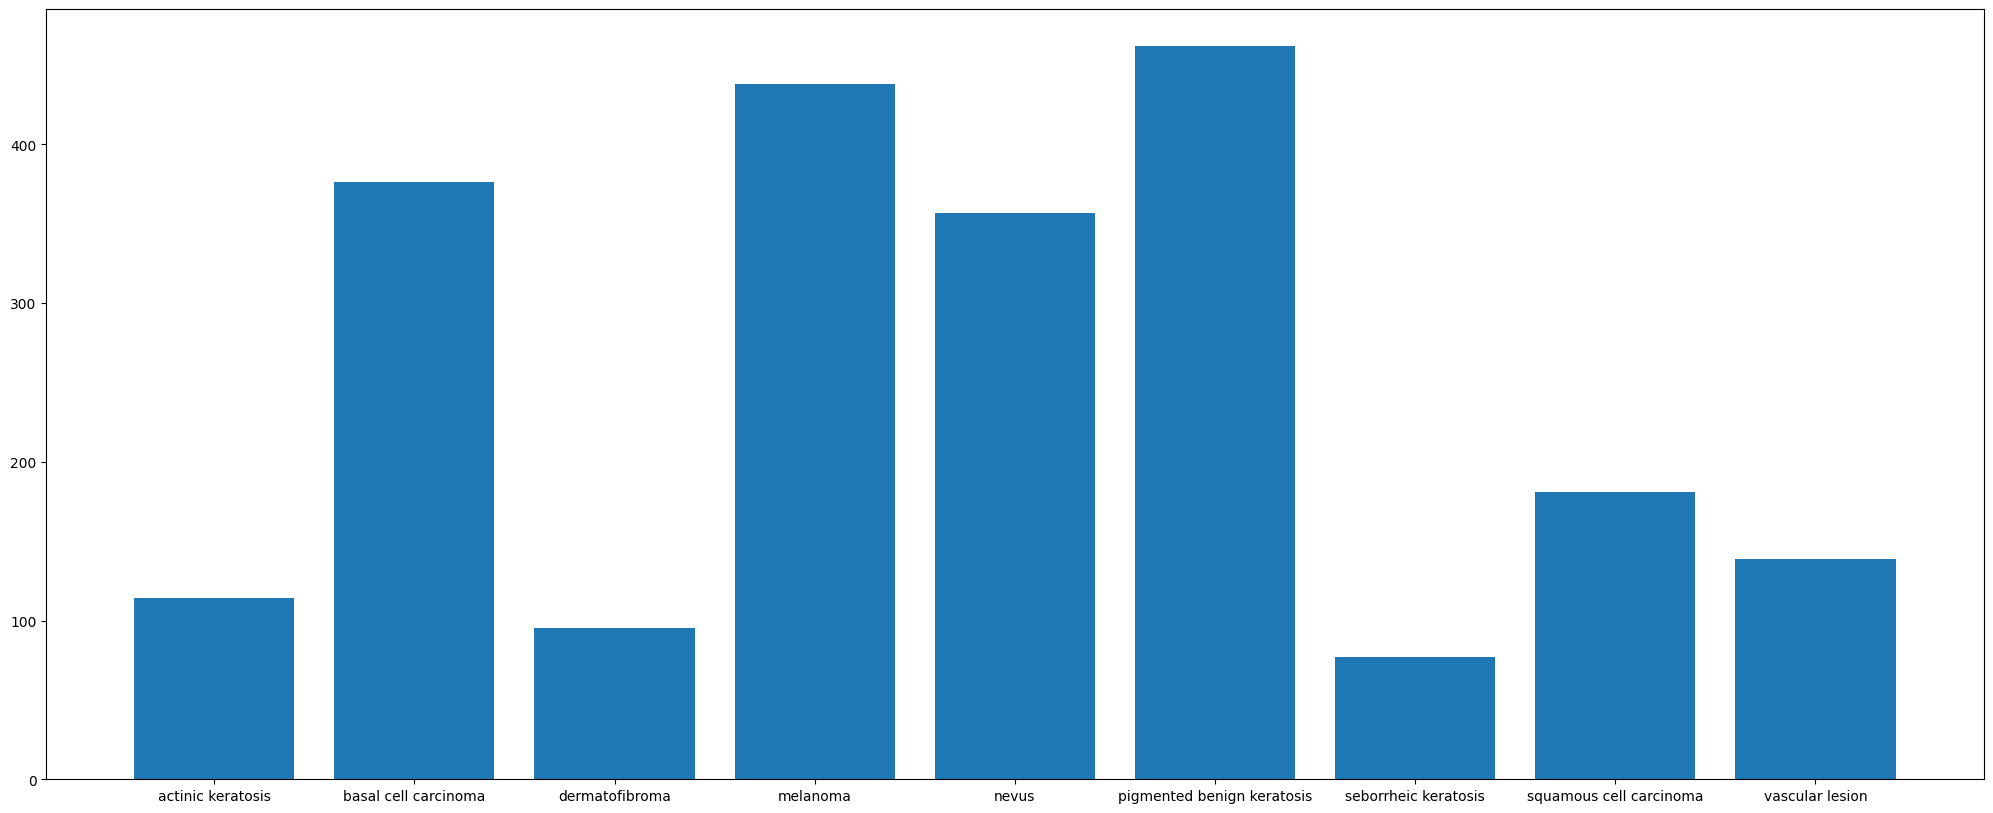

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### Write your findings here:
#### - Which class has the least number of samples?
-- seborrheic Keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
Melanoma and Pigmented benign keratosis
actinic keratosis and  dermatofibroma


#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

In [ ]:
path_to_training_dataset='/content/drive/MyDrive/Education/Master/artifacts/upgrad/melanoma cnn assignment/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0240DA0040>: 100%|██████████| 500/500 [00:21<00:00, 23.27 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D02405AE650>: 100%|██████████| 500/500 [00:21<00:00, 23.69 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0240588130>: 100%|██████████| 500/500 [00:21<00:00, 23.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D0240EAA950>: 100%|██████████| 500/500 [01:30<00:00,  5.54 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=957x640 at 0x7D025C8931C0>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0240E1D2D0>: 100%|██████████| 500/500 [00:17<00:00, 28.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D0240DDD720>: 100%|██████████| 500/500 [00:41<00:00, 12.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D025C193160>: 100%|██████████| 500/500 [00:17<00:00, 29.17 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0240D7E9B0>: 100%|██████████| 500/500 [00:17<00:00, 28.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [5]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

9000

In [6]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

9000

In [ ]:
df_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(df_dict_new.items()),columns = ['Path','Label'])
classes_df = original_df.append(df2)

<ipython-input-45-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [ ]:
classes_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### : Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/Education/Master/artifacts/upgrad/melanoma cnn assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Creating model

In [ ]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### Compile the model

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## using 50 epochs.


lc = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
history = model.fit(
  train_ds,
    callbacks=[lc],
  validation_data=val_ds,
  epochs=epochs

)

Epoch 1/50
169/169 [==============================] - 54s 264ms/step - loss: 2.1609 - accuracy: 0.1641 - val_loss: 2.1195 - val_accuracy: 0.1715 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 37s 214ms/step - loss: 1.9819 - accuracy: 0.2385 - val_loss: 1.8050 - val_accuracy: 0.3022 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 37s 215ms/step - loss: 1.7458 - accuracy: 0.3153 - val_loss: 1.5069 - val_accuracy: 0.3979 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 36s 206ms/step - loss: 1.6111 - accuracy: 0.3776 - val_loss: 1.5288 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 40s 231ms/step - loss: 1.5215 - accuracy: 0.4060 - val_loss: 1.4599 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 37s 216ms/step - loss: 1.4797 - accuracy: 0.4216 - val_loss: 1.3438 - val_accuracy: 0.4484 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

#### **Todo:**  Visualize the model results

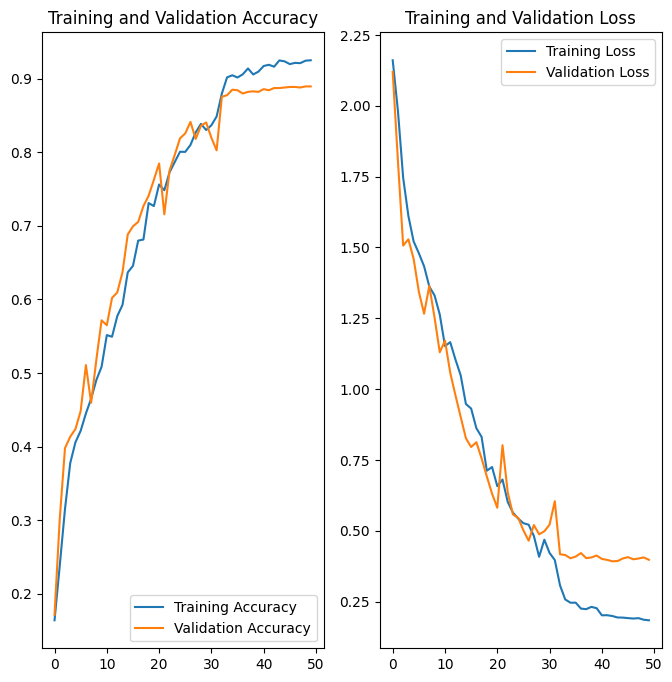

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysing the results. Did you get rid of underfitting/overfitting? Did class rebalance help?

- the validation accuracy is .889
- Training and validation accuracy follow eachother
- Same pattern can be seen with with Training and Validation loss.
- was able to get rid of  underfitting/overfitting to an extent



1/1 [==============================] - 0s 22ms/step
Actual Class: nevus
Predictive Class: nevus


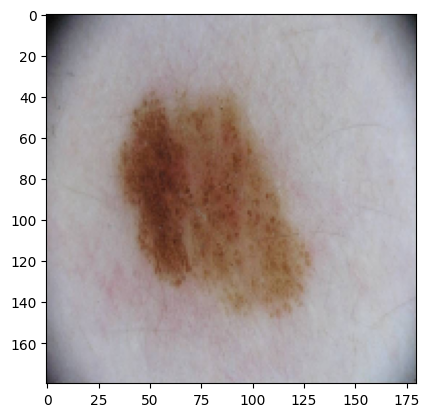

In [ ]:
#Running the model on test data
import pathlib
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(pathlib.Path('/content/drive/MyDrive/Education/Master/artifacts/upgrad/melanoma cnn assignment/Test/'), class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[2]}" + '\n' + "Predictive Class: " + pred_class)

1/1 [==============================] - 0s 25ms/step
Actual Class: pigmented benign keratosis
Predictive Class: pigmented benign keratosis


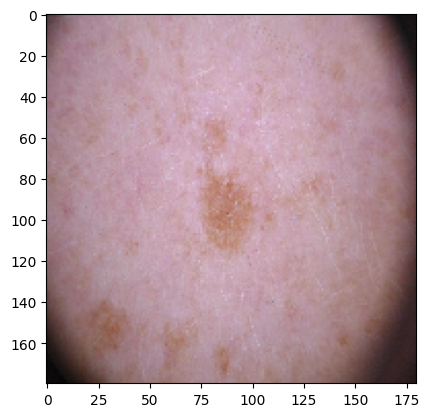

In [ ]:
#Running the model on test data
import pathlib
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
actual_class_name = class_names[5]
Test_image_path = os.path.join(pathlib.Path('/content/drive/MyDrive/Education/Master/artifacts/upgrad/melanoma cnn assignment/Test'),actual_class_name , '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {actual_class_name}" + '\n' + "Predictive Class: " + pred_class)